In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

import fbprophet 

import glob
import sklearn
import torch
%matplotlib inline

## Extract the training data and validation data from row data

In [2]:
ABM_data_path = r'../correct_counting_for_rki_dataset_and_SEICRD/do_nothing_reduced.csv'
ABM_data = pd.read_csv(ABM_data_path)
population_size = 1000 
print("---------------ABM row data---------------")
print(ABM_data.head(3))

ABM_data_ = pd.DataFrame() 
ABM_data_['infected']= ABM_data[1::14]['Avg'] * population_size
ABM_data_['Date'] = pd.date_range('3/1/2020', periods=len(ABM_data_['infected']), freq='D')

ABM_data_ = ABM_data_.reset_index(drop=True)
ABM_data_ = ABM_data_.set_index('Date', drop=True)
# remove 0
#ABM_data_ = ABM_data_.replace(0, np.nan)
#ABM_data_ = ABM_data_.dropna()
print("---------------infection number data---------------")
print(ABM_data_.head(3))


# select training data from 01.03 to 30.03
training_data = ABM_data_[datetime.date(2020,3,1):datetime.date(2020,3,30)]
print("---------------training data---------------")
print(training_data.head(3))


# select validate data from 01.04 to 30.04
valid_data = ABM_data_[datetime.date(2020,4,1):datetime.date(2020,4,30)]
print("---------------validation data---------------")
print(valid_data.head(3)) 


---------------ABM row data---------------
   Iteration            Metric    Min       Avg       Std    Max
0          0       Susceptible  0.968  0.969333  0.000943  0.970
1          0          Infected  0.020  0.020667  0.000943  0.022
2          0  Recovered_Immune  0.010  0.010000  0.000000  0.010
---------------infection number data---------------
              infected
Date                  
2020-03-01   20.666667
2020-03-02   21.333333
2020-03-03  128.333333
---------------training data---------------
              infected
Date                  
2020-03-01   20.666667
2020-03-02   21.333333
2020-03-03  128.333333
---------------validation data---------------
              infected
Date                  
2020-04-01  276.000000
2020-04-02  223.666667
2020-04-03  166.000000


## Plot (_df for dataframe, _list for array) 

In [3]:
def three_labels_df(train, forcast, valid, title):
    plt.plot(train, color="blue", label="training data") 
    plt.plot(forcast, color="green",  label="prediction data")
    plt.plot(valid, color="yellow",  label="validation data") 
    plt.legend(loc='upper left')
    plt.title(title)

def three_labels_list(train, forcast, valid, title):
    predict_len = len(forcast)
    restart_day = len(train) - 1
    plt.plot(train, color="blue", label="training data") 
    plt.plot(range(restart_day, restart_day + predict_len), forcast, color="green",  label="prediction data")
    plt.plot(range(restart_day, restart_day + predict_len), valid, color="yellow",  label="validation data")
    plt.legend(loc='upper left') 
    plt.title(title)

## AutoReg 

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


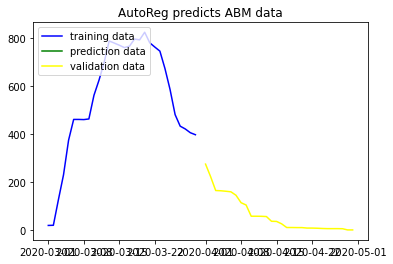

In [4]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random

# fit model
model = AutoReg(training_data, lags=1)
model_fit = model.fit()

# make prediction
predict_len = len(valid_data)
restart_day = len(training_data) - 1
yhat = model_fit.predict(restart_day, restart_day + predict_len - 1)

three_labels_df(training_data, yhat, valid_data, "AutoReg predicts ABM data")

## ARMA 

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


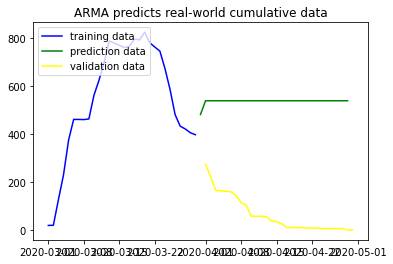

In [5]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(training_data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
train_len = len(training_data)
valid_len = len(valid_data)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
#print(yhat)

three_labels_df(training_data, yhat, valid_data, "ARMA predicts real-world cumulative data")

In [6]:
arma_sq_error = sqrt(mean_squared_error(yhat, valid_data))
print('mean square error: ' + str(arma_sq_error))

mean square error: 478.8090142439486


## ExponentSmoothing 

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


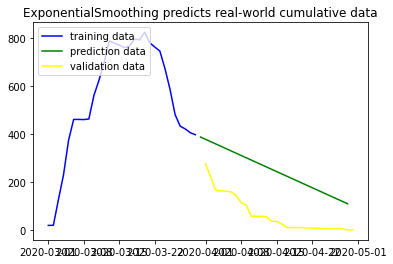

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 
model = ExponentialSmoothing(training_data, trend='add', damped=False, seasonal=None, seasonal_periods=0)
model_fit = model.fit()
# make prediction
train_len = len(training_data)
valid_len = len(valid_data)
yhat = model_fit.predict(train_len, train_len + valid_len - 1)
#print(yhat)

three_labels_df(training_data, yhat, valid_data, "ExponentialSmoothing predicts real-world cumulative data")


In [27]:
ex_sq_error = sqrt(mean_squared_error(yhat, valid_data))
print('mean square error: ' + str(ex_sq_error))

mean square error: 187.8677940760432


## FBprophet 

In [7]:
# fit the column names to waht fbprophet demanded
fb_train = pd.DataFrame()
fb_train['ds'] = training_data.index 
fb_train['y'] = training_data.values
fb_train.head(3) 

fb_valid = pd.DataFrame()
fb_valid['ds'] = valid_data.index 
fb_valid['y'] = valid_data.values
fb_valid.head(3) 

,ds,y
0,2020-04-01,276.000000
1,2020-04-02,223.666667
2,2020-04-03,166.000000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
D:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


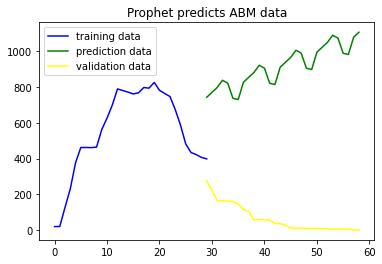

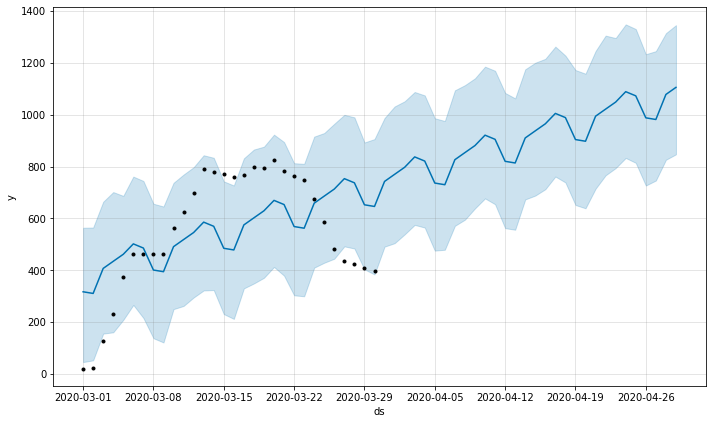

In [8]:
pro = fbprophet.Prophet()
pro.fit(fb_train)
pro_periods = len(valid_data)
future = pro.make_future_dataframe(periods=pro_periods, freq='D')
forecast = pro.predict(future)
three_labels_list(training_data.values, forecast['yhat'][len(training_data):], valid_data.values, "Prophet predicts ABM data")
fig = pro.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), pro, forecast)

In [9]:
fb_sq_error = sqrt(mean_squared_error(forecast['yhat'][len(training_data):], valid_data.values))
print('mean square error: ' + str(fb_sq_error))

mean square error: 866.7547363980062


## initialize LSTM model  (inspired by https://romanorac.github.io/machine/learning/2019/09/27/time-series-prediction-with-lstm.html)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
train_arr = scaler.fit_transform(training_data.values)
val_arr = scaler.transform(valid_data.values)

In [11]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [12]:
seq_len_batch_size = 6 

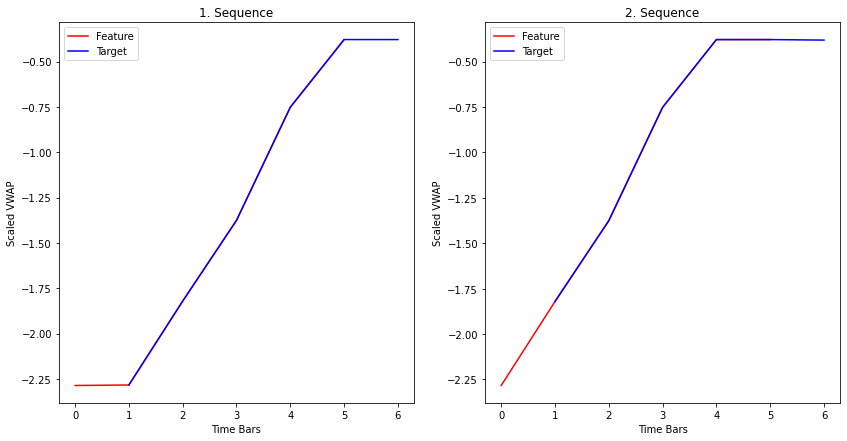

In [13]:
from torch.autograd import Variable

seq_len = seq_len_batch_size

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)

def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [14]:
import torch.nn as nn
import torch.optim as optim
import time
import random

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
    
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch
            
    def train(
        self,
        x_train,
        y_train,
        x_val,
        y_val,
        batch_size,
        n_epochs,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                
            self.scheduler.step()
            train_loss /= batch_size
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch_size 
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch_size
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [15]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

## LSTM

Epoch 1 Train loss: 0.35. Validation loss: 2.78. Avg future: 0.00. Elapsed time: 0.54s.
Epoch 2 Train loss: 0.34. Validation loss: 2.76. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 3 Train loss: 0.33. Validation loss: 2.74. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 4 Train loss: 0.33. Validation loss: 2.72. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 5 Train loss: 0.32. Validation loss: 2.70. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 6 Train loss: 0.32. Validation loss: 2.68. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 7 Train loss: 0.31. Validation loss: 2.68. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 8 Train loss: 0.31. Validation loss: 2.68. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 9 Train loss: 0.31. Validation loss: 2.68. Avg future: 0.00. Elapsed time: 0.02s.
Epoch 10 Train loss: 0.31. Validation loss: 2.68. Avg future: 0.00. Elapsed time: 0.02s.
Test loss 2.7091


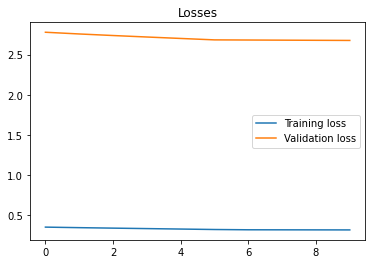

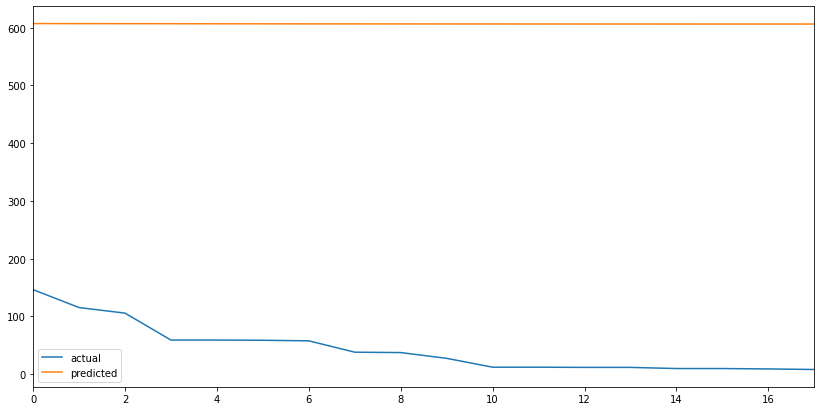

In [16]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, seq_len_batch_size, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
optimization_1.train(x_train, y_train, x_val, y_val, seq_len_batch_size,
        n_epochs=10, do_teacher_forcing=False)

optimization_1.plot_losses()

actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=5, batch_size=seq_len_batch_size)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

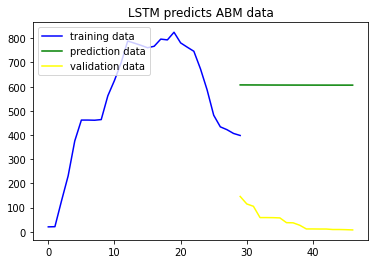

In [17]:
three_labels_list(training_data.values, df_result_1['predicted'], df_result_1['actual'], "LSTM predicts ABM data" )

In [18]:
lstm_sq_error = sqrt(mean_squared_error(df_result_1['predicted'], df_result_1['actual']))
print('mean square error: ' + str(lstm_sq_error))

mean square error: 564.3894669811591


## Teacher Forcing

Epoch 1 Train loss: 0.48. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Epoch 2 Train loss: 0.47. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Epoch 3 Train loss: 0.46. Validation loss: 1.71. Avg future: 1.67. Elapsed time: 0.02s.
Epoch 4 Train loss: 0.45. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Epoch 5 Train loss: 0.44. Validation loss: 1.71. Avg future: 1.33. Elapsed time: 0.02s.
Epoch 6 Train loss: 0.43. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Epoch 7 Train loss: 0.43. Validation loss: 1.71. Avg future: 1.67. Elapsed time: 0.02s.
Epoch 8 Train loss: 0.42. Validation loss: 1.71. Avg future: 1.33. Elapsed time: 0.02s.
Epoch 9 Train loss: 0.42. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Epoch 10 Train loss: 0.43. Validation loss: 1.71. Avg future: 2.00. Elapsed time: 0.02s.
Test loss 1.8167


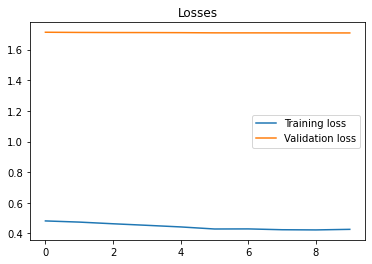

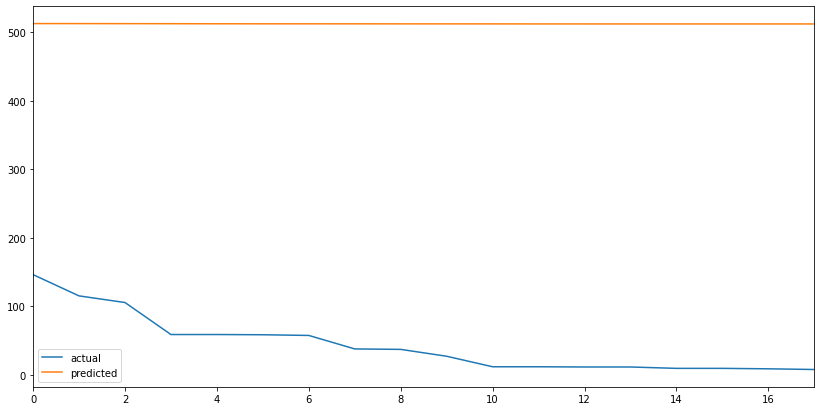

In [19]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, seq_len_batch_size, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2, optimizer_2, scheduler_2)
optimization_2.train(x_train, y_train, x_val, y_val, seq_len_batch_size,
        n_epochs=10, do_teacher_forcing=True)

optimization_2.plot_losses()

actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_val, y_val, future=5, batch_size=seq_len_batch_size)
df_result_2 = to_dataframe(actual_2, predicted_2) 
df_result_2 = inverse_transform(scaler, df_result_2, ['actual', 'predicted'])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)



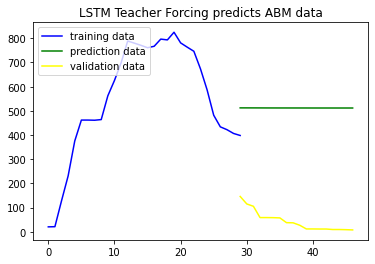

In [20]:
three_labels_list(training_data.values, df_result_2['predicted'], df_result_2['actual'], "LSTM Teacher Forcing predicts ABM data" )

In [21]:
teacher_sq_error = sqrt(mean_squared_error(df_result_2['predicted'], df_result_2['actual']))
print('mean square error: ' + str(teacher_sq_error))

mean square error: 469.9871645382343


## Mean sqare errors 

Text(0.5, 1.0, 'Mean square errors of four approaches')

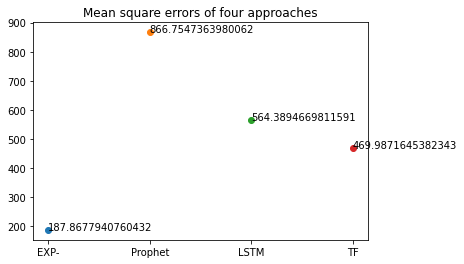

In [30]:
ax = plt.subplot()
labels = ["EXP-", "Prophet", "LSTM", "TF"]
errors = [ex_sq_error, fb_sq_error,  lstm_sq_error, teacher_sq_error]
for i in range(len(errors)):
    ax.scatter(labels[i], errors[i])
    ax.annotate(errors[i], (labels[i], errors[i]))
plt.title("Mean square errors of four approaches")